In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='', count_swaps_df='',
    verbose=False
)
triage_paper_df = data_frames_list['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 401177 332 111
file_stats_df = data_frames_list['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 332 332 19
scene_stats_df = data_frames_list['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 486 332 48
count_swaps_df = data_frames_list['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 331 331 3

triage_paper_df 401177 332 111
file_stats_df 332 332 19
scene_stats_df 486 332 48
count_swaps_df 331 331 3


In [4]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    file_stats_df,
    scene_stats_df.merge(count_swaps_df, on=fu.scene_groupby_columns, how='inner'),
    needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category'],
    patient_count_filter_fn=patient_count_filter_fn
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 117

elevens_df 397230 331 118


In [5]:

# Get a dataset of only first11 patients
nongrouped_patients_list = nu.load_object('nongrouped_patients_list')
mask_series = ~elevens_df.patient_id.isin(nongrouped_patients_list)
elevens_df = elevens_df[mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 388745 331 117

elevens_df 388745 331 118


In [6]:

# for the "Other" label, instead, put back whether they were Faculty or something else (Nurse, etc.)
mask_series = (elevens_df.responder_category == 'Other')
elevens_df.loc[mask_series, 'responder_category'] = elevens_df.loc[mask_series, 'overall_category']


## For the requests below only use n = 324 (filter out 4 faculty, 1 nurse, and Other HP from this analysis). The remaining n should breakdown should be as follows:
 - EMT-Paramedic = 224
 - EMT-Basic = 23
 - EM-Resident = 32
 - Medical Student = 45

In [7]:

CATEGORY_DICT = {'Paramedic': 'EMT-Paramedic', 'EMT-Basic': 'EMT-Basic', 'EM Resident': 'EM-Resident', 'Medical Student': 'Medical Student'}
mask_series = elevens_df.responder_category.isin(list(CATEGORY_DICT.keys()))
gb = elevens_df[mask_series].groupby('responder_category')
tuples_list = [(CATEGORY_DICT[responder_category], '=', df.session_uuid.nunique()) for responder_category, df in gb]
for category_tuple in sorted(tuples_list, key=lambda x: list(CATEGORY_DICT.values()).index(x[0])): print(*category_tuple)

EMT-Paramedic = 224
EMT-Basic = 23
EM-Resident = 32
Medical Student = 45



## Boxplots for the 4 measures below (maybe add colors and mean). If you could add the raw data points via jitter like below, that would be great.

In [8]:

# Get whisker plot for various measures
import seaborn as sns
import matplotlib.pyplot as plt
from random import uniform  # for jitter

temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
def get_plot_dataframe(
    y_column_name, scene_fn, logs_df=elevens_df, x_column_name='responder_category', responder_categories_list=list(CATEGORY_DICT.keys()), verbose=False
):
    '''
    The order and labeling should be (from left to right):
        EMT-Paramedic
        EMT-Basic
        EM-Resident
        Medical Student
    '''
    rows_list = []
    for responder_category in responder_categories_list:
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        if verbose: print('session_uuid in responder_categories_df:', bool('session_uuid' in responder_categories_df.columns))
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            if verbose: print('session_uuid in scene_df:', bool('session_uuid' in scene_df.columns))
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)
    
    return df

In [9]:

def adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn=temporalize_fn):
    
    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(ytick_fn(ytick_value))
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(CATEGORY_DICT[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

In [10]:

import matplotlib.markers as markers

# Get all marker styles from matplotlib.markers
all_markers = markers.MarkerStyle.markers
all_markers

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}

In [11]:

def show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False):
    df = get_plot_dataframe(y_column_name, scene_fn, logs_df=logs_df, verbose=verbose)
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])
    responder_categories_list = list(CATEGORY_DICT.keys())

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot under the scatter plot; put a black square for the mean instead
    ax = sns.boxplot(
        ax=ax,
        data=df,
        fliersize=0.0,
        meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 8},
        showmeans=True,
        x=x_column_name,
        y=y_column_name,
    )

    # Jitter amount
    jitter_amt = 0.1  # Adjust this value to control jitter range

    # Add jittered points
    sns.stripplot(
        alpha=0.25,  # Adjust transparency
        ax=ax,
        color='black',
        data=df,
        jitter=jitter_amt,  # Add jitter
        s=6,  # Adjust marker size
        x=x_column_name,
        y=y_column_name,
    )
    
    adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn)
    plt.show()


## The y-axis labels should be as follows:


 - Triage Tag Accuracy

In [12]:

# Iterate through each patient of each scene of each session of the 11-patient data frame
rows_list = []
for responder_category, responder_categories_df in elevens_df.groupby('responder_category'):
    for (session_uuid, scene_id, patient_id), patient_df in responder_categories_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns):

        # Get non-null tag applied types and patient record SALTs
        mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
        if mask_series.any():
            tags_and_salts_df = patient_df[mask_series]

            # Add the groupby columns and an account of the patient's existence to the row dictionary
            row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
            row_dict['responder_category'] = responder_category
            row_dict['patient_count'] = 1

            # Add the TAG_APPLIED tag value for this patient
            last_tag = fu.get_last_tag(tags_and_salts_df)
            row_dict['last_tag'] = last_tag

            # Add the PATIENT_RECORD SALT value for this patient
            max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
            row_dict['max_salt'] = max_salt

            # Add the predicted tag value for this patient based on the SALT value
            try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
            except Exception: predicted_tag = np.nan
            row_dict['predicted_tag'] = predicted_tag

            # Add if the tagging was correct for this patient, then the row to the list
            row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)
            rows_list.append(row_dict)

# Create the tag-to-SALT data frame
tag_to_salt_df = pd.DataFrame(rows_list)

# Convert the tagged, SALT, and predicted tag columns to their custom categorical types
tag_to_salt_df.last_tag = tag_to_salt_df.last_tag.astype(fu.colors_category_order)
tag_to_salt_df.max_salt = tag_to_salt_df.max_salt.astype(fu.salt_category_order)
tag_to_salt_df.predicted_tag = tag_to_salt_df.predicted_tag.astype(fu.colors_category_order)

# Sort the data frame based on the custom categorical orders
tag_to_salt_df = tag_to_salt_df.sort_values('predicted_tag')

In [13]:

# Get the total and correct counts for each run for each tag
rows_list = []

# Add the normal section
groupby_columns = ['session_uuid', 'scene_id', 'predicted_tag']
for responder_category, responder_categories_df in tag_to_salt_df.groupby('responder_category'):
    for (session_uuid, scene_id, predicted_tag), df in responder_categories_df.groupby(groupby_columns):
        
        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in groupby_columns}
        row_dict['responder_category'] = responder_category

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

    # Add the not-tagged section
    for (session_uuid, scene_id), df in responder_categories_df.groupby(fu.scene_groupby_columns):

        # Add the groupby columns to the row dictionary
        row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
        row_dict['predicted_tag'] = 'Not Tagged'
        row_dict['responder_category'] = responder_category

        # Add the total and correct counts for this run
        mask_series = (df.is_tag_correct == True)
        correct_count = df[mask_series].patient_count.sum()
        row_dict['correct_count'] = correct_count
        total_count = df.patient_count.sum()
        row_dict['total_count'] = total_count

        # Add percentage that tag is correct
        try: percentage_tag_correct = 100*correct_count/total_count
        except Exception: percentage_tag_correct = np.nan
        row_dict['percentage_tag_correct'] = percentage_tag_correct

        # Add the row dictionary to the list
        rows_list.append(row_dict)

# Create the correct count data frame
correct_count_by_tag_df = pd.DataFrame(rows_list)
correct_count_by_tag_df.predicted_tag = correct_count_by_tag_df.predicted_tag.astype(fu.colors_category_order)

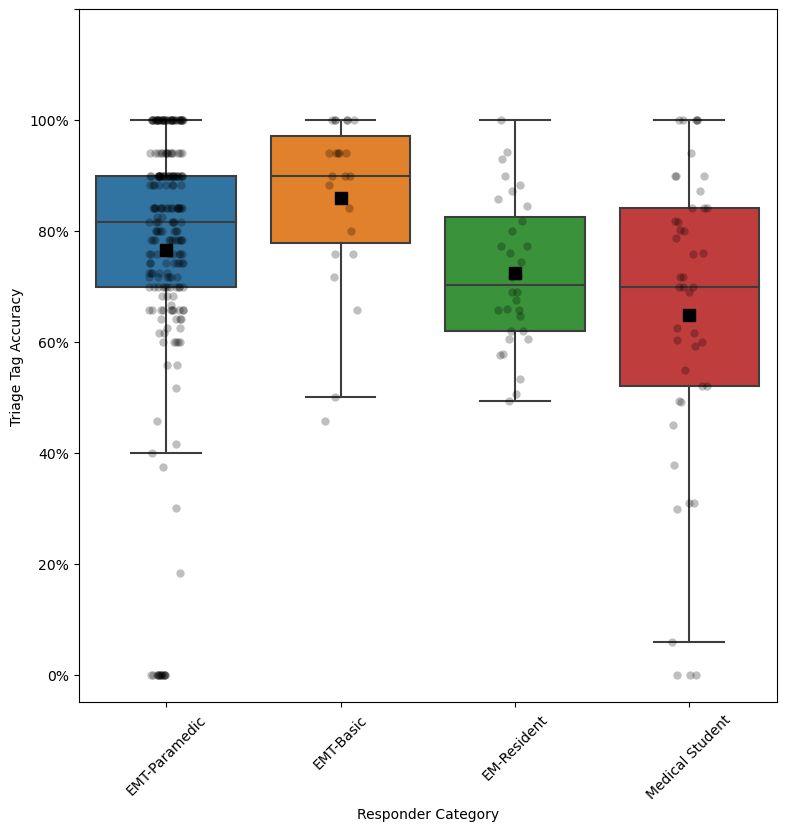

In [14]:

y_column_name = 'percentage_tag_correct'
y_label = 'Triage Tag Accuracy'
scene_fn = lambda scene_df: scene_df[y_column_name].mean()
percents_fn = lambda x: f'{int(x)}%' if (x<=100) else ''
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=percents_fn, logs_df=correct_count_by_tag_df)

bodies
<class 'matplotlib.collections.PolyCollection'>
['set_aa', 'set_agg_filter', 'set_alpha', 'set_animated', 'set_antialiased', 'set_antialiaseds', 'set_array', 'set_capstyle', 'set_clim', 'set_clip_box', 'set_clip_on', 'set_clip_path', 'set_cmap', 'set_color', 'set_dashes', 'set_ec', 'set_edgecolor', 'set_edgecolors', 'set_facecolor', 'set_facecolors', 'set_fc', 'set_figure', 'set_gid', 'set_hatch', 'set_in_layout', 'set_joinstyle', 'set_label', 'set_linestyle', 'set_linestyles', 'set_linewidth', 'set_linewidths', 'set_ls', 'set_lw', 'set_norm', 'set_offset_transform', 'set_offsets', 'set_path_effects', 'set_paths', 'set_picker', 'set_pickradius', 'set_rasterized', 'set_sizes', 'set_sketch_params', 'set_snap', 'set_transform', 'set_url', 'set_urls', 'set_verts', 'set_verts_and_codes', 'set_visible', 'set_zorder']
cmeans
<class 'matplotlib.collections.LineCollection'>
['set_aa', 'set_agg_filter', 'set_alpha', 'set_animated', 'set_antialiased', 'set_antialiaseds', 'set_array', 'set_

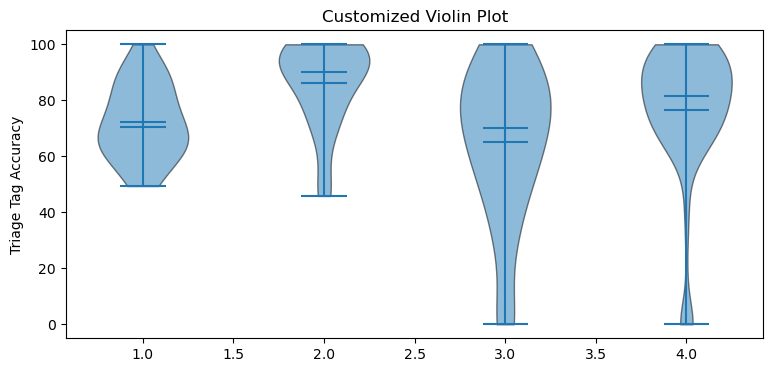

In [29]:

import numpy as np

# Generate some test data (replace with your actual data)
y_column_name = 'percentage_tag_correct'
scene_fn = lambda scene_df: scene_df[y_column_name].mean()
df = get_plot_dataframe(
    y_column_name, scene_fn, logs_df=correct_count_by_tag_df, verbose=False
)
data = [responder_category_df.percentage_tag_correct.tolist() for _, responder_category_df in df.groupby('responder_category')]

fig, ax = plt.subplots(figsize=(9, 4))
ax.set_title('Customized Violin Plot')
y_label = 'Triage Tag Accuracy'
ax.set_ylabel(y_label)

# Create the violin plot
parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)
for key, parts_list in parts.items():
    print(key)
    if not isinstance(parts_list, list):
        print(type(parts_list))
        print([fn for fn in dir(parts_list) if fn.startswith('set_')])
    else:
        for pc in parts_list:
            print(type(pc))
            print([fn for fn in dir(pc) if fn.startswith('set_')])
            break

# Customize the appearance of the violins
for pc in parts['bodies']:
    pc.set_facecolor(None)       # Set the fill color
    pc.set_edgecolor('black')    # Set the edge color
    pc.set_alpha(0.5)
    pc.set_zorder(0)             # Artists with lower zorder values are drawn first

In [30]:

parts

{'bodies': [<matplotlib.collections.PolyCollection object at 0x7ff273375890>, <matplotlib.collections.PolyCollection object at 0x7ff273375d10>, <matplotlib.collections.PolyCollection object at 0x7ff2733758d0>, <matplotlib.collections.PolyCollection object at 0x7ff273375d90>], 'cmeans': <matplotlib.collections.LineCollection object at 0x7ff27336b890>, 'cmaxes': <matplotlib.collections.LineCollection object at 0x7ff273375790>, 'cmins': <matplotlib.collections.LineCollection object at 0x7ff273375750>, 'cbars': <matplotlib.collections.LineCollection object at 0x7ff273389d10>, 'cmedians': <matplotlib.collections.LineCollection object at 0x7ff273319ad0>}

In [18]:

# Add slim boxplot with mean line
x_column_name = 'responder_category'
sns.boxplot(
    autorange=False,
    ax=ax,
    # bootstrap=None,
    boxprops=dict(alpha=1),
    # capprops=None,
    # color=None,
    # conf_intervals=None,
    data=df,
    dodge=True,
    # flierprops=None,
    fliersize=0,
    # hue=None,
    # hue_order=None,
    # labels=None,
    linewidth=1.5,
    manage_ticks=True,
    meanline=False,
    meanprops={'color': 'black'},
    # medianprops=None,
    # notch=None,
    # order=None,
    # orient=None,
    # palette=None,
    # patch_artist=None,
    # positions=None,
    saturation=0.75,
    showbox=True,
    showcaps=False,
    # showfliers=None,
    showmeans=False,
    # sym=None,
    # usermedians=None,
    # vert=None,
    whis=1.5,
    # whiskerprops=None,
    width=0.25,
    # widths=None,
    x=x_column_name,
    y=y_column_name,
    zorder=1,
)

['set_aa', 'set_agg_filter', 'set_alpha', 'set_animated', 'set_antialiased', 'set_antialiaseds', 'set_array', 'set_capstyle', 'set_clim', 'set_clip_box', 'set_clip_on', 'set_clip_path', 'set_cmap', 'set_color', 'set_dashes', 'set_ec', 'set_edgecolor', 'set_edgecolors', 'set_facecolor', 'set_facecolors', 'set_fc', 'set_figure', 'set_gid', 'set_hatch', 'set_in_layout', 'set_joinstyle', 'set_label', 'set_linestyle', 'set_linestyles', 'set_linewidth', 'set_linewidths', 'set_ls', 'set_lw', 'set_norm', 'set_offset_transform', 'set_offsets', 'set_path_effects', 'set_paths', 'set_picker', 'set_pickradius', 'set_rasterized', 'set_sizes', 'set_sketch_params', 'set_snap', 'set_transform', 'set_url', 'set_urls', 'set_verts', 'set_verts_and_codes', 'set_visible', 'set_zorder']

In [19]:

pc.set_zorder?

Signature: pc.set_zorder(level)
Docstring:
Set the zorder for the artist.  Artists with lower zorder
values are drawn first.

Parameters
----------
level : float
File:      ~/anaconda3/envs/itm_analysis_reporting/lib/python3.7/site-packages/matplotlib/artist.py
Type:      method



 - Time to Triage Scene

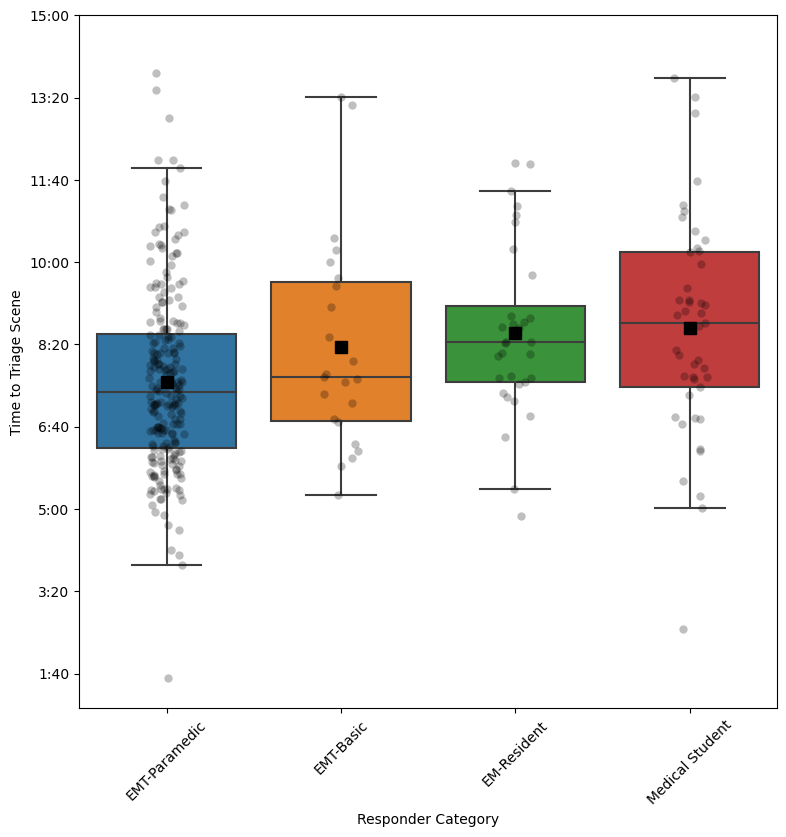

In [225]:

y_column_name = 'triage_time'
y_label = 'Time to Triage Scene'
scene_fn = lambda scene_df: fu.get_triage_time(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, verbose=False)


 - Hemorrhage Control for all Life-threatening Bleeding (if that doesnt fit, just do Hemorrhage Control)

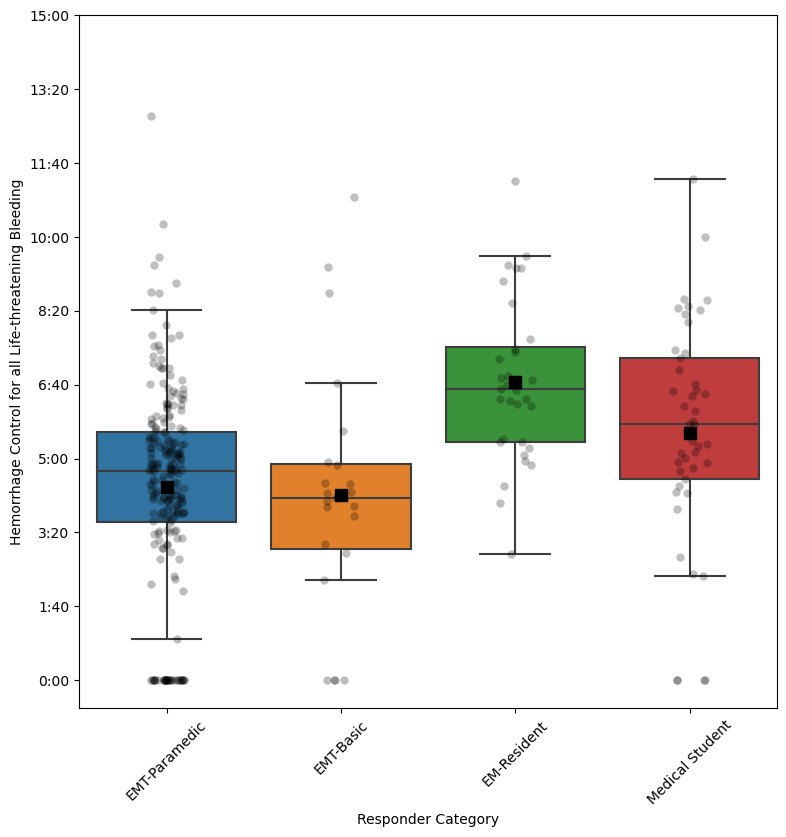

In [226]:

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Hemorrhage Control for all Life-threatening Bleeding'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


 - Hemorrhage Control per Patient

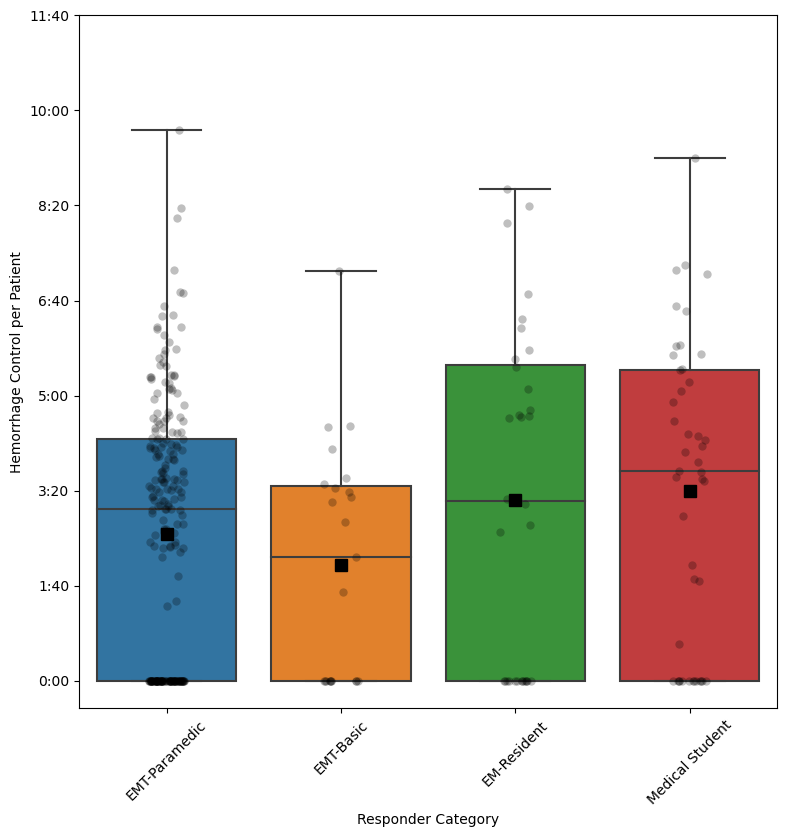

In [227]:

y_column_name = 'time_to_hemorrhage_control'
y_label = 'Hemorrhage Control per Patient'
scene_fn = lambda scene_df: fu.get_time_to_hemorrhage_control(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


## Stacked graph for triage errors

In [42]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['last_tag', 'max_salt', 'responder_category']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])

In [47]:

# Get triage error rates
import re

rows_list = []
for responder_category, responder_categories_df in error_types_df.groupby('responder_category'):
    row_dict = {'responder_category': responder_category}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
triage_error_rates_df = DataFrame(rows_list)

In [81]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
def show_stacked_horizontal_bar_chart(rates_df, ylabel=''):
    labels_list = list(CATEGORY_DICT.values())[::-1]
    over_values, under_values, critical_values = [], [], []
    for column_value in list(CATEGORY_DICT.keys())[::-1]:
        mask_series = (rates_df.responder_category == column_value)
        over_values.append(rates_df[mask_series].over_triage_error_rate.squeeze())
        under_values.append(rates_df[mask_series].under_triage_error_rate.squeeze())
        critical_values.append(rates_df[mask_series].critical_triage_error_rate.squeeze())
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(labels_list, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(labels_list, under_values, color='#717171', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    # The data labels for critical errors should be in white (for better contrast)
    critical_bar = plt.barh(
        labels_list, critical_values, color='#bb0000', label=suffixing_fn('Critical'), left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center', color='black', fontsize=8
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1, 0.62), loc='center right')
    plt.grid(False)
    
    # Display the chart
    plt.show()


## The order and labeling should be (from top to bottom):
 - EMT-Paramedic
 - EMT-Basic
 - EM-Resident
 - Medical Student

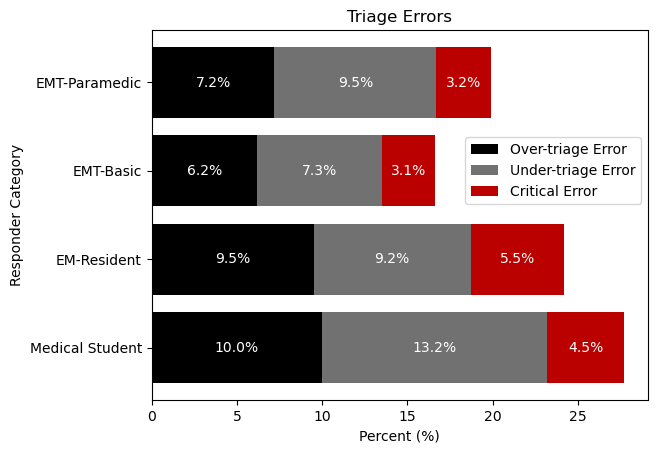

In [82]:

show_stacked_horizontal_bar_chart(triage_error_rates_df, ylabel='Responder Category')


## Please add to the excel data sheet, the triage errors. Please use three separate columns for under, over, and critical.

In [105]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['session_uuid', 'last_tag', 'max_salt', 'responder_category']
anova_error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
anova_error_types_df['error_type'] = anova_error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
anova_error_types_df['last_tag'] = anova_error_types_df['last_tag'].astype(fu.colors_category_order)
anova_error_types_df['max_salt'] = anova_error_types_df['max_salt'].astype(fu.salt_category_order)
anova_error_types_df['error_type'] = anova_error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
anova_error_types_df = anova_error_types_df.sort_values(by=groupby_columns+['error_type'])

In [106]:

anova_error_types_df

,session_uuid,last_tag,max_salt,responder_category,patient_count,error_type
0,009b848c-ea64-4f22-bd40-711213a3d327,black,DEAD,EM Resident,0,Exact
1,009b848c-ea64-4f22-bd40-711213a3d327,black,DEAD,EM-Faculty,0,Exact
2,009b848c-ea64-4f22-bd40-711213a3d327,black,DEAD,EMT-Basic,0,Exact
3,009b848c-ea64-4f22-bd40-711213a3d327,black,DEAD,Medical Student,0,Exact
4,009b848c-ea64-4f22-bd40-711213a3d327,black,DEAD,Nurse,0,Exact
...,...,...,...,...,...,...
69295,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,Not Tagged,MINIMAL,EMT-Basic,0,NaN
69296,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,Not Tagged,MINIMAL,Medical Student,0,NaN
69297,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,Not Tagged,MINIMAL,Nurse,0,NaN
69298,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,Not Tagged,MINIMAL,Other HP,0,NaN


In [110]:

# Get triage error rates
import re

rows_list = []
for (session_uuid, responder_category), responder_categories_df in anova_error_types_df.groupby(['session_uuid', 'responder_category']):
    row_dict = {'responder_category': responder_category, 'session_uuid': session_uuid}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
anova_error_rates_df = DataFrame(rows_list)

In [112]:

mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
gb = elevens_df[mask_series].groupby(['session_uuid', 'responder_category'])
rows_list = []
for i, ((session_uuid, responder_category), session_df) in enumerate(gb):
    largest_tuple = sorted([(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')], key=lambda x: x[1])[-1]
    responder_categories_df = largest_tuple[0]
    row_dict = {'ID': f'Responder {i+1}', 'Group': responder_category, 'session_uuid': session_uuid}
    row_dict['TtTS'] = fu.get_triage_time(responder_categories_df)
    row_dict['TtHC'] = fu.get_time_to_last_hemorrhage_controlled(responder_categories_df)
    times_list = []
    for _, patient_df in responder_categories_df.groupby('patient_id'):
        if fu.get_is_patient_hemorrhaging(patient_df):
            controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=None)
            times_list.append(controlled_time)
    row_dict['MTfHCpP'] = Series(times_list).mean()
    scene_id = largest_tuple[2]
    mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
    mask_series &= (correct_count_by_tag_df.responder_category == responder_category)
    if mask_series.any(): row_dict['MPAT'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
    
    # Add the triage errors
    mask_series = (anova_error_rates_df.responder_category == responder_category) & (anova_error_rates_df.session_uuid == session_uuid)
    over_triage_error_rate = anova_error_rates_df[mask_series].over_triage_error_rate.squeeze()
    if not isinstance(over_triage_error_rate, Series): row_dict['over_triage_error_rate'] = over_triage_error_rate
    under_triage_error_rate = anova_error_rates_df[mask_series].under_triage_error_rate.squeeze()
    if not isinstance(under_triage_error_rate, Series): row_dict['under_triage_error_rate'] = under_triage_error_rate
    critical_triage_error_rate = anova_error_rates_df[mask_series].critical_triage_error_rate.squeeze()
    if not isinstance(critical_triage_error_rate, Series): row_dict['critical_triage_error_rate'] = critical_triage_error_rate
    
    rows_list.append(row_dict)
anova_df = DataFrame(rows_list)
nu.save_data_frames(anova_df=anova_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/anova_df.csv
